<a href="https://colab.research.google.com/github/crescent98/machinelearning35911/blob/master/assignment11_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import six
import numpy as np
import cupy as cp
import math

In [2]:
import cupy as cp
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Google Drive Mounted

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
review_data = load_files(r"/content/drive/My Drive/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [6]:
#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = cp.sum(d)
    # r = np.sqrt(s)

    return(s)

Normalization

In [14]:
X_train_gpu=cp.array(X_train)
X_test_gpu=cp.array(X_test)

Functions

In [7]:
# ndarray를 받았을 때 vector 곱과 sigmoid 연산
def nextA(x,theta):
  mul=cp.matmul(theta,x)
  return 1/(1+cp.exp(-mul))

In [199]:
# 4 thetas

theta_1=cp.random.normal(0,0.1,(1300,1501))
theta_2=cp.random.normal(0,0.1,(300,1301))
theta_3=cp.random.normal(0,0.1,(200,301))
theta_4=cp.random.normal(0,0.1,(1,201))
"""
theta_1=np.random.normal(0.1,0,(1000,1501))
theta_2=np.random.normal(0.1,0,(600,1001))
theta_3=np.random.normal(0.1,0,(400,601))
theta_4=np.random.normal(0.1,0,(250,401))
theta_5=np.random.normal(0.1,0,(1,251))
"""

'\ntheta_1=np.random.normal(0.1,0,(1000,1501))\ntheta_2=np.random.normal(0.1,0,(600,1001))\ntheta_3=np.random.normal(0.1,0,(400,601))\ntheta_4=np.random.normal(0.1,0,(250,401))\ntheta_5=np.random.normal(0.1,0,(1,251))\n'

In [200]:
train_objective=cp.zeros(5000)
train_accuracy=cp.zeros(5000)

test_objective=cp.zeros(5000)
test_accuracy=cp.zeros(5000)

train_ans=cp.zeros(1401)
test_ans=cp.zeros(601)

theta_size=cp.size(theta_1)+cp.size(theta_2)+cp.size(theta_3)+cp.size(theta_4)

m=1401 #train은 1401회

In [201]:
alpha=0.3
lamb=1000

In [176]:
i=0

Neural Network Algorithm

In [228]:
while(i!=1000):

  #training
  b_delta5=0
  b_delta4=0
  b_delta3=0
  b_delta2=0

  objective_sum=0

  cor_count=0
  theta_aver=(cp.sum(cp.square(theta_1))+cp.sum(cp.square(theta_2))+cp.sum(cp.square(theta_3))+cp.sum(cp.square(theta_4)))/theta_size
  
  #training
  for j in range(0,1400):

    # Forward Propagation

    a1=X_train_gpu[j]
    a1_=cp.concatenate((cp.ones(1),a1))
    a2=nextA(a1_,theta_1)
    a2_=cp.concatenate((cp.ones(1),a2))
    a3=nextA(a2_,theta_2)
    a3_=cp.concatenate((cp.ones(1),a3))
    a4=nextA(a3_,theta_3)
    a4_=cp.concatenate((cp.ones(1),a4))
    a5=nextA(a4_,theta_4)
    a5_=cp.concatenate((cp.ones(1),a5))

    # Compute Delta5
    delta_5=a5-y_train[j]

    # Compute Delta4, Delta3, Delta2
    delta_4=cp.matmul(cp.transpose(theta_4),delta_5)*a4_*(1-a4_)
    delta_3=cp.matmul(cp.transpose(theta_3),delta_4[1:])*a3_*(1-a3_)
    delta_2=cp.matmul(cp.transpose(theta_2),delta_3[1:])*a2_*(1-a2_)

    # Compute(accumulate) big Delta5, Delta4, Delta3, Delta2
    b_delta5=b_delta5+cp.matmul(delta_5.reshape(1,1),a4_.reshape(1,201))
    b_delta4=b_delta4+cp.matmul(delta_4[1:].reshape(200,1),a3_.reshape(1,301))
    b_delta3=b_delta3+cp.matmul(delta_3[1:].reshape(300,1),a2_.reshape(1,1301))
    b_delta2=b_delta2+cp.matmul(delta_2[1:].reshape(1300,1),a1_.reshape(1,1501))
  
    # Compute(accumulate) Objective
    # L is based on the Correct Answer(Y)
    objective_sum=objective_sum+(-y_train[j]*cp.log(a5))-(1-y_train[j])*cp.log(1-a5)
    if math.isnan(objective_sum):
      print(j,"nan이 검출되었습니다")
      sys.exit()
    # Compute the calculated_answer
    if a5>1/2:
      train_ans[j]=1
      if y_train[j]==1:
        cor_count=cor_count+1
    else:
      train_ans[j]=0
      if y_train[j]==0:
        cor_count=cor_count+1

  #Setting new Theta
  theta_4=theta_4-alpha*(b_delta5/1401+lamb*theta_4/theta_size)
  theta_3=theta_3-alpha*(b_delta4/1401+lamb*theta_3/theta_size)
  theta_2=theta_2-alpha*(b_delta3/1401+lamb*theta_2/theta_size)
  theta_1=theta_1-alpha*(b_delta2/1401+lamb*theta_1/theta_size)
  
  
  # Testing
  ans2=0
  cor_count2=0
  objective_sum2=0

  theta_aver=(cp.sum(cp.square(theta_1))+cp.sum(cp.square(theta_2))+cp.sum(cp.square(theta_3))+cp.sum(cp.square(theta_4)))/theta_size  
  for j in range(0,601):

    # Compute a5 for objective (Forward Propagation)

    a1=X_test_gpu[j]
    a1_=cp.concatenate((cp.ones(1),a1))
    a2=nextA(a1_,theta_1)
    a2_=cp.concatenate((cp.ones(1),a2))
    a3=nextA(a2_,theta_2)
    a3_=cp.concatenate((cp.ones(1),a3))
    a4=nextA(a3_,theta_3)
    a4_=cp.concatenate((cp.ones(1),a4))
    a5=nextA(a4_,theta_4)
    a5_=cp.concatenate((cp.ones(1),a5))

    # Computing(accumulating) Objective Function
    objective_sum2=objective_sum2+(-y_test[j]*cp.log(a5))-(1-y_test[j])*cp.log(1-a5)

    # Compute the answer
    if a5>1/2:
      test_ans[j]=1
      if y_test[j]==1:
        cor_count2=cor_count2+1
    else:
      test_ans[j]=0
      if y_test[j]==0:
        cor_count2=cor_count2+1
    
  #Compute the accuracy
  train_accuracy[i]=cor_count/1401
  test_accuracy[i]=cor_count2/601

  # Calcluate the Objective Function
  train_objective[i]=objective_sum[0]/1401+theta_aver*lamb/2
  test_objective[i]=objective_sum2[0]/601+theta_aver*lamb/2

  # Next 
  i=i+1


# ***1. Plot the Loss Curve***

In [229]:
train_objective_np=cp.asnumpy(train_objective)
test_objective_np=cp.asnumpy(test_objective)

train: blue test: red


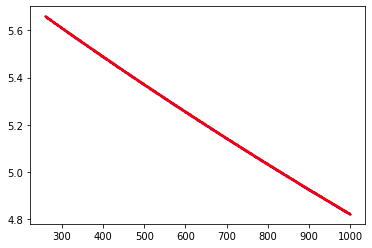

In [230]:
plt.scatter(range(260,i),train_objective_np[260:i],c="#0000ff",label='blue',s=1)
plt.scatter(range(260,i),test_objective_np[260:i],c="#ff0000",label="red",s=1)
print("train: blue test: red")

train: blue test: red


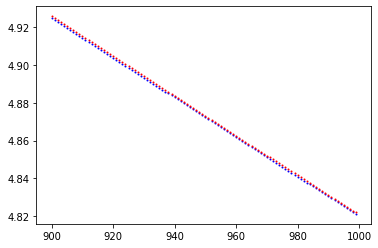

In [237]:
plt.scatter(range(900,i),train_objective_np[900:i],c="#0000ff",label='blue',s=1)
plt.scatter(range(900,i),test_objective_np[900:i],c="#ff0000",label="red",s=1)
print("train: blue test: red")

# ***2. Plot the Accuracy Curve***

In [232]:
train_accuracy_np=cp.asnumpy(train_accuracy)
test_accuracy_np=cp.asnumpy(test_accuracy)

train: blue test: red


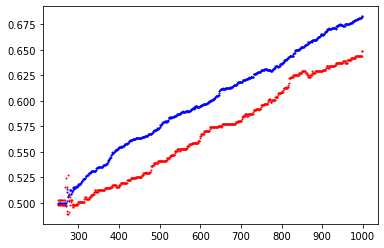

In [233]:
plt.scatter(range(250,i),train_accuracy_np[250:i],c="#0000ff",label="blue",s=1)
plt.scatter(range(250,i),test_accuracy_np[250:i],c="#ff0000",label="red",s=1)
print("train: blue test: red")

# ***3. Plot the quantitative results***

In [234]:
train_ans_np=cp.asnumpy(train_ans)
test_ans_np=cp.asnumpy(test_ans)

In [235]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_train,train_ans_np))
print(classification_report(y_train,train_ans_np))
print(accuracy_score(y_train, train_ans_np))

print(confusion_matrix(y_test,test_ans_np))
print(classification_report(y_test,test_ans_np))
print(accuracy_score(y_test,test_ans_np))

[[338 361]
 [ 83 619]]
              precision    recall  f1-score   support

           0       0.80      0.48      0.60       699
           1       0.63      0.88      0.74       702

    accuracy                           0.68      1401
   macro avg       0.72      0.68      0.67      1401
weighted avg       0.72      0.68      0.67      1401

0.683083511777302
[[127 175]
 [ 36 263]]
              precision    recall  f1-score   support

           0       0.78      0.42      0.55       302
           1       0.60      0.88      0.71       299

    accuracy                           0.65       601
   macro avg       0.69      0.65      0.63       601
weighted avg       0.69      0.65      0.63       601

0.64891846921797


# ***4. Testing Accuracy***

In [236]:
print("The Final testing accuracy is: ",test_accuracy[i-1])

The Final testing accuracy is:  0.64891846921797
